In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2

from keras.activations import *
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D,MaxPooling2D,Flatten,Dense,Dropout,LSTM,GRU
from sklearn.metrics import classification_report,accuracy_score, precision_score, recall_score, f1_score ,confusion_matrix
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score
from yellowbrick.classifier import PrecisionRecallCurve, ROCAUC, ConfusionMatrix


/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: libtensorflow_io.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so: undefined symbol: _ZTVN10tenso

In [2]:
x_train = pd.read_csv(r"/kaggle/input/ahcd1/csvTrainImages 13440x1024.csv",header=None)
y_train = pd.read_csv(r"/kaggle/input/ahcd1/csvTrainLabel 13440x1.csv",header=None)

x_test = pd.read_csv(r"/kaggle/input/ahcd1/csvTestImages 3360x1024.csv",header=None)
y_test = pd.read_csv(r"/kaggle/input/ahcd1/csvTestLabel 3360x1.csv",header=None)

print("x_train.shape =", x_train.shape, "\ny_train.shape =", 
      y_train.shape, "\nx_test.shape =", x_test.shape, "\ny_test.shape =", y_test.shape)

x_train.shape = (13440, 1024) 
y_train.shape = (13440, 1) 
x_test.shape = (3360, 1024) 
y_test.shape = (3360, 1)


In [3]:
x_train = x_train.iloc[:,:].values
x_test = x_test.iloc[:,:].values
y_train = y_train.iloc[:,:].values
y_test = y_test.iloc[:,:].values
print("x_train.shape =", x_train.shape, "\ny_train.shape =", 
      y_train.shape, "\nx_test.shape =", x_test.shape, "\ny_test.shape =", y_test.shape)

x_train.shape = (13440, 1024) 
y_train.shape = (13440, 1) 
x_test.shape = (3360, 1024) 
y_test.shape = (3360, 1)


In [4]:
x_train = x_train.reshape(-1,32,32,1)
x_test = x_test.reshape(-1,32,32,1)

x_train = x_train / 255.0
x_test = x_test / 255.0

print(x_train.shape, x_test.shape)

(13440, 32, 32, 1) (3360, 32, 32, 1)


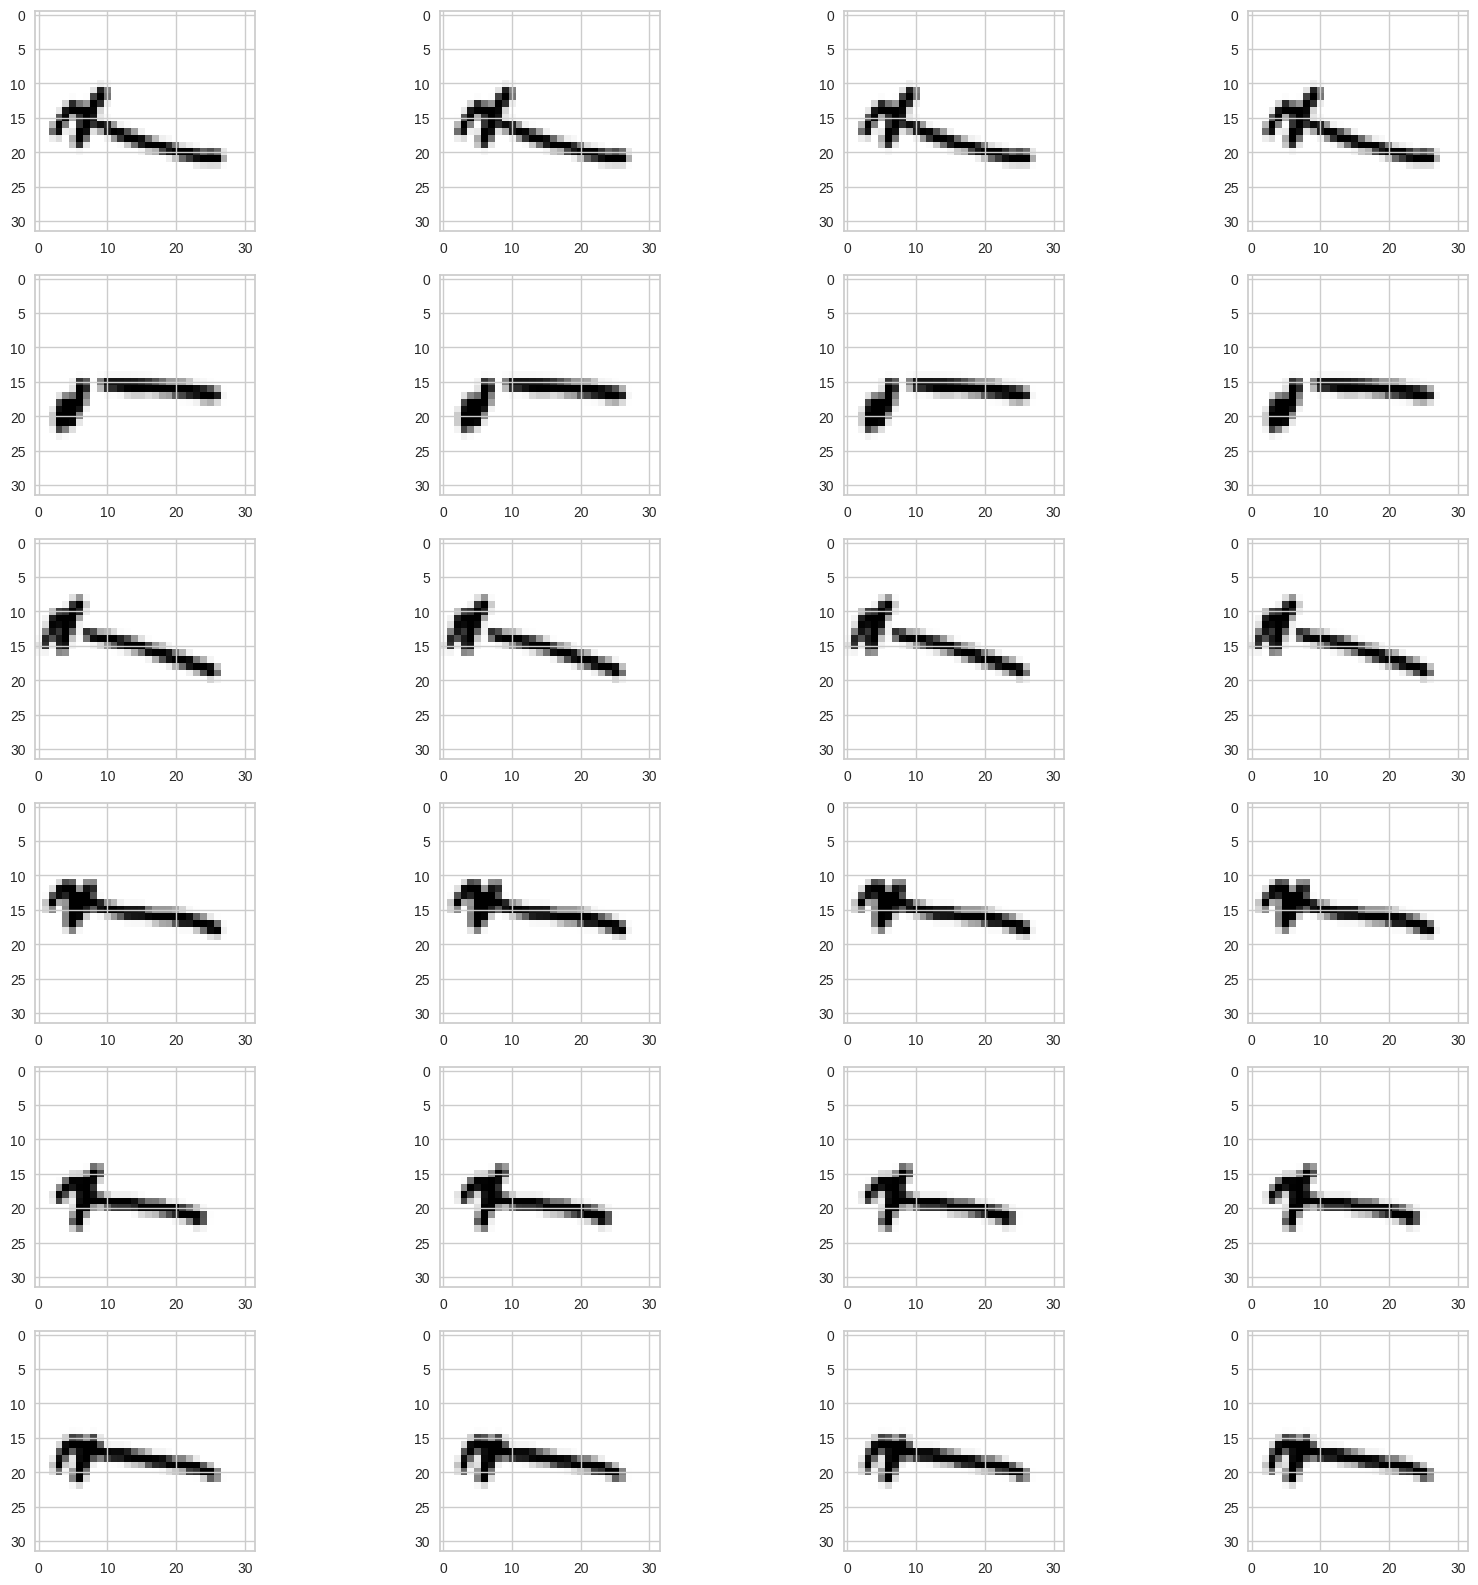

In [5]:
fig, ax = plt.subplots(6,4,figsize=(20,20))

for i in range(6):
    for j in range(4):
        ax[i,j].imshow(x_train[i])

In [6]:
total_classes = len(np.unique(y_train))+1
y_train = to_categorical(y_train,total_classes)
y_test = to_categorical(y_test, total_classes)

print(y_train.shape)
print(y_test.shape)

(13440, 29)
(3360, 29)


In [7]:
from tensorflow.keras import layers
import tensorflow.keras.backend as K
from tensorflow.keras.layers import Input,Conv1D,Flatten,BatchNormalization,SpatialDropout1D, MaxPooling1D,Dense,GlobalMaxPooling1D,Embedding
class attention(layers.Layer):
    def _init_(self,**kwargs):
        super(attention,self)._init_(**kwargs)

    def build(self,input_shape):
        self.W=self.add_weight(name="att_weight",shape=(input_shape[-1],1),initializer="normal")
        self.b=self.add_weight(name="att_bias",shape=(input_shape[1],1),initializer="zeros")        
        super(attention, self).build(input_shape)

    def call(self,x):
        et=K.squeeze(K.tanh(K.dot(x,self.W)+self.b),axis=-1)
        at=K.softmax(et)
        at=K.expand_dims(at,axis=-1)
        output=x*at
        return K.sum(output,axis=1)

    def compute_output_shape(self,input_shape):
        return (input_shape[0],input_shape[-1])

    def get_config(self):
        return super(attention,self).get_config()

In [8]:
model = Sequential([
    
    
    LSTM(256, return_sequences=True, dropout=0.25, input_shape=(32,32)),
    Dense(256, activation='relu'),
    
    LSTM(128, return_sequences=True, dropout=0.5),
    Dense(128, activation='relu'),
    
    LSTM(64, return_sequences=True, dropout=0.5),
    Dense(64, activation='relu'),
    
    LSTM(32, return_sequences=True, dropout=0.5),
    Dense(32, activation='relu'),
    
    attention(),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(256, activation='relu'),
    Dense(total_classes, activation='softmax')
])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 32, 256)           295936    
                                                                 
 dense (Dense)               (None, 32, 256)           65792     
                                                                 
 lstm_1 (LSTM)               (None, 32, 128)           197120    
                                                                 
 dense_1 (Dense)             (None, 32, 128)           16512     
                                                                 
 lstm_2 (LSTM)               (None, 32, 64)            49408     
                                                                 
 dense_2 (Dense)             (None, 32, 64)            4160      
                                                                 
 lstm_3 (LSTM)               (None, 32, 32)            1

In [9]:
model.compile(loss='categorical_crossentropy', optimizer='adam', 
                  metrics=['accuracy'])

In [10]:
history = model.fit(x_train,y_train,
                    #steps_per_epoch=len(x_train)//128,
                    batch_size=128,
                    epochs=150,
                    validation_data=(x_test, y_test),
                   # validation_steps=50
                   )

Epoch 1/150
105/105 [==============================] - 15s 31ms/step - loss: 2.9562 - accuracy: 0.1042 - val_loss: 2.4698 - val_accuracy: 0.1955
Epoch 2/150
105/105 [==============================] - 2s 16ms/step - loss: 2.3357 - accuracy: 0.2127 - val_loss: 2.0343 - val_accuracy: 0.2693
Epoch 3/150
105/105 [==============================] - 2s 17ms/step - loss: 2.0128 - accuracy: 0.2812 - val_loss: 1.7076 - val_accuracy: 0.3393
Epoch 4/150
105/105 [==============================] - 2s 17ms/step - loss: 1.7453 - accuracy: 0.3592 - val_loss: 1.5260 - val_accuracy: 0.4247
Epoch 5/150
105/105 [==============================] - 2s 17ms/step - loss: 1.5352 - accuracy: 0.4291 - val_loss: 1.3536 - val_accuracy: 0.4509
Epoch 6/150
105/105 [==============================] - 2s 17ms/step - loss: 1.3852 - accuracy: 0.4734 - val_loss: 1.1907 - val_accuracy: 0.5467
Epoch 7/150
105/105 [==============================] - 2s 17ms/step - loss: 1.2496 - accuracy: 0.5304 - val_loss: 1.0553 - val_accuracy

In [11]:
y_held_pred=model.predict(x_test)

105/105 [==============================] - 2s 6ms/step


In [12]:
y_pred=np.argmax(y_held_pred, axis=1)
y_test_1=np.argmax(y_test, axis=1)

print(y_test_1.shape)
print(y_pred.shape)

(3360,)
(3360,)


In [13]:
model.evaluate(x_test,y_test)

105/105 [==============================] - 1s 8ms/step - loss: 0.2309 - accuracy: 0.9491


[0.23094555735588074, 0.9491071701049805]

In [14]:
his=model.evaluate(x_test, y_test, verbose=2);
print(his)

105/105 - 1s - loss: 0.2309 - accuracy: 0.9491 - 755ms/epoch - 7ms/step
[0.23094555735588074, 0.9491071701049805]


In [15]:
y_held_pred_train=model.predict(x_train)

420/420 [==============================] - 2s 5ms/step


In [16]:
y_pred_train=np.argmax(y_held_pred_train, axis=1)
y_train_1=np.argmax(y_train, axis=1)

print(y_train_1.shape)
print(y_pred_train.shape)
model.evaluate(x_train, y_train, verbose=2);

(13440,)
(13440,)
420/420 - 3s - loss: 0.0092 - accuracy: 0.9972 - 3s/epoch - 7ms/step


<Axes: title={'center': 'Actual vs. Predicted'}, xlabel='Actual G*', ylabel='Predicted G*'>

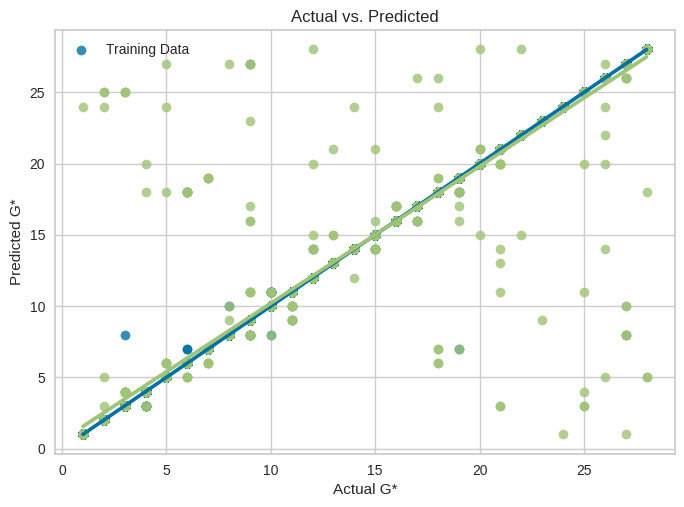

In [17]:
import seaborn as sns

sns.regplot(x=y_train_1,y=y_pred_train, label="Training Data")

plt.xlabel('Actual G*')
plt.ylabel('Predicted G*')
plt.title('Actual vs. Predicted')
plt.legend(loc="upper left")

sns.regplot(x=y_test_1,y=y_pred, label="Testing Data")

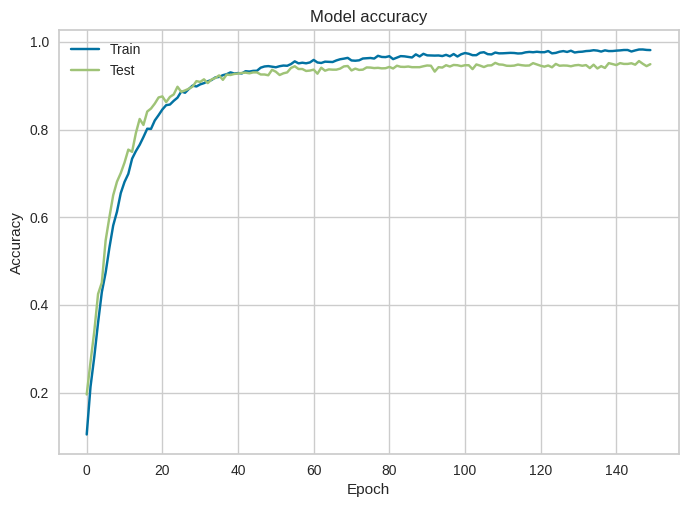

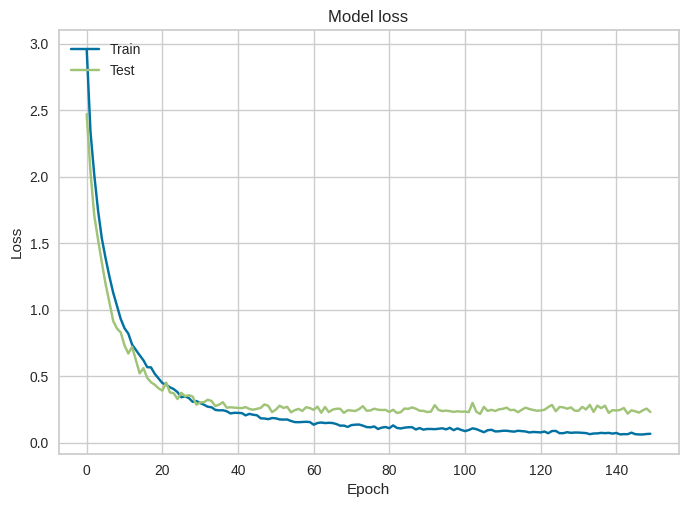

In [18]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [19]:
y_predicted = model.predict(x_test)
y_grand_truth = y_test
y_predicted = np.argmax(y_predicted,axis=1)
y_grand_truth = np.argmax(y_grand_truth,axis=1)
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_grand_truth, y_predicted)

105/105 [==============================] - 1s 5ms/step


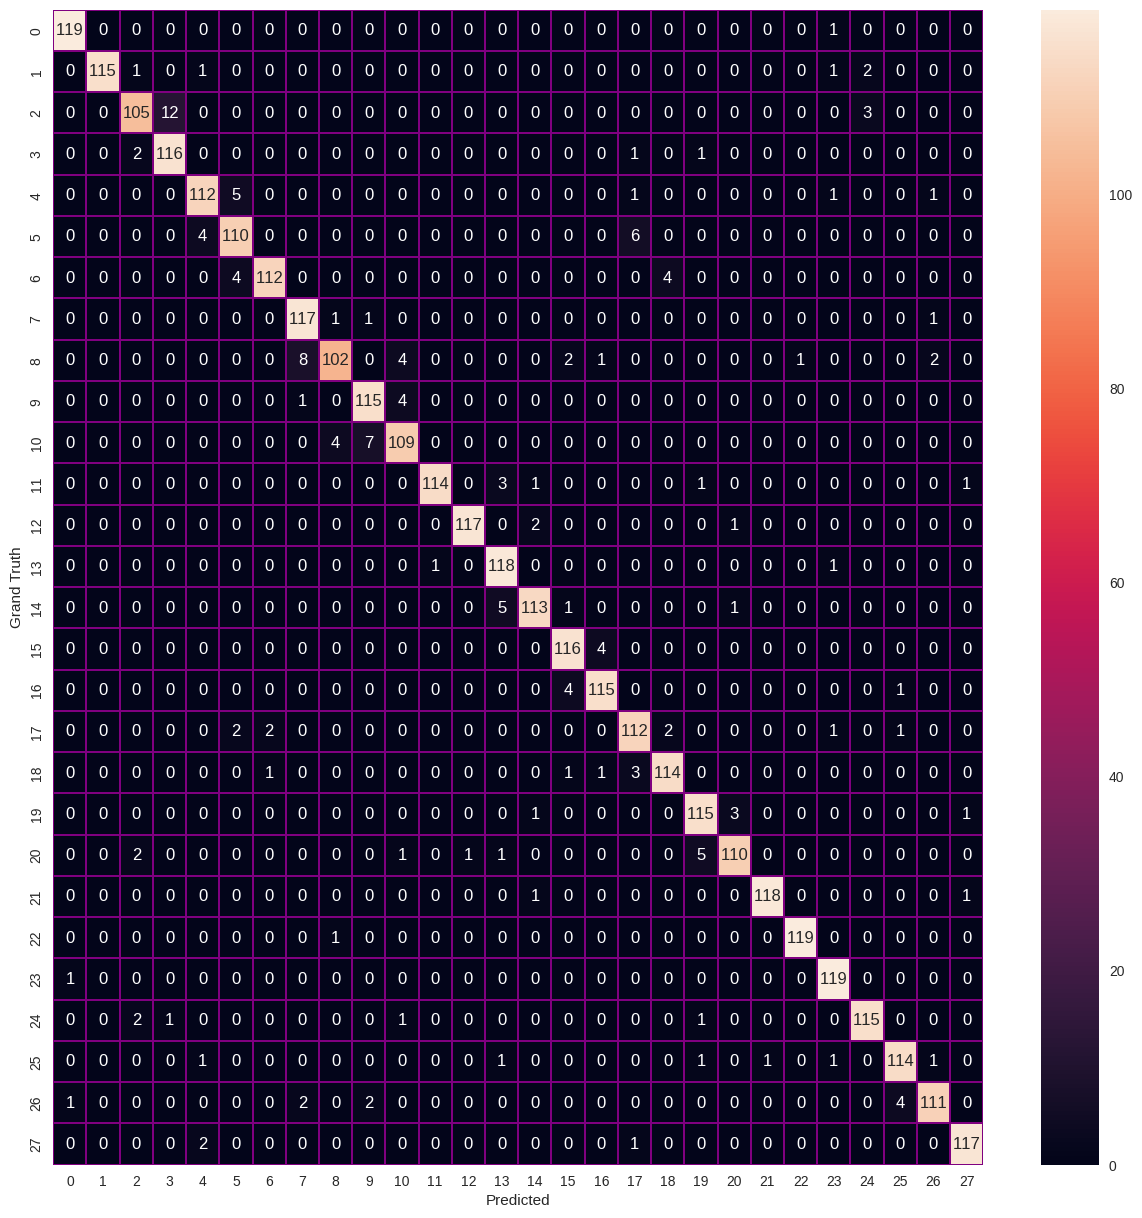

In [20]:
f, ax = plt.subplots(figsize=(15,15))
sns.heatmap(cm,fmt=".0f", annot=True,linewidths=0.2, linecolor="purple", ax=ax)
plt.xlabel("Predicted")
plt.ylabel("Grand Truth")
plt.show()

In [21]:
scores = np.zeros((28,3))
def calc_F1(num):
  TP = cm[num,num]
  FN = np.sum(cm[num,:])-cm[num,num]
  FP = np.sum(cm[:,num])-cm[num,num]
  precision = TP/(TP+FP)
  recall = TP/(TP+FN)
  F1_score = 2*(recall * precision) / (recall + precision)
  return precision, recall, F1_score
for i in range(28):
   precision, recall, F1_score = calc_F1(i)
   scores[i,:] = precision, recall, F1_score
scores_frame = pd.DataFrame(scores,columns=["Precision", "Recall", "F1 Score"], index=[list(range(0, 28))])

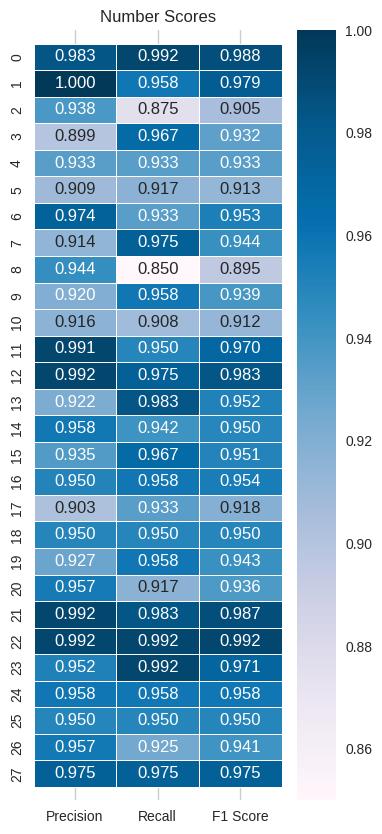

In [22]:
f, ax = plt.subplots(figsize = (4,10))
ax.set_title('Number Scores')
sns.heatmap(scores_frame, annot=True, fmt=".3f", linewidths=0.5, cmap="PuBu", cbar=True, ax=ax)
bottom, top = ax.get_ylim()
plt.ylabel("")
ax.set_ylim(bottom + 0.5, top - 0.5)
plt.show()

In [23]:
# Functions: Performance Evaluation 

def Performance(Model , y_predd): 
    
    # model accuracy
    accuracy = accuracy_score(y_test_1, y_predd)
    print( Model +' Accuracy:'+'\033[1m {:.2f}%'.format(accuracy*100))
    
    # model Classification Report
    print('\nClassification Report: '+'\033[0m')
    print('*' * 22)
    print(classification_report(y_test_1, y_predd))

In [24]:
Performance('LSTM' , y_pred)

LSTM Accuracy: 94.91%

Classification Report: 
**********************
              precision    recall  f1-score   support

           1       0.98      0.99      0.99       120
           2       1.00      0.96      0.98       120
           3       0.94      0.88      0.91       120
           4       0.90      0.97      0.93       120
           5       0.93      0.93      0.93       120
           6       0.91      0.92      0.91       120
           7       0.97      0.93      0.95       120
           8       0.91      0.97      0.94       120
           9       0.94      0.85      0.89       120
          10       0.92      0.96      0.94       120
          11       0.92      0.91      0.91       120
          12       0.99      0.95      0.97       120
          13       0.99      0.97      0.98       120
          14       0.92      0.98      0.95       120
          15       0.96      0.94      0.95       120
          16       0.94      0.97      0.95       120
          1







### 